# Circulation
This plots the stream function when monsoon is occuring in summer, and just prior to this at the equinox.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
matplotlib.rcParams['lines.linewidth'] = 0.8          # make lines bigger for presentation

In [3]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat, clausius_clapeyron_factor
from isca_tools.utils.constants import g, R, radius_earth, c_p, L_v
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_z_ft_approx
from isca_tools.utils.circulation import get_stream
from isca_tools.utils.calculus import grad_y

In [4]:
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
tau_lw_cold = 1
tau_lw_warm = 2
exp_names = [f"k={str(tau_lw_cold).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
# exp_dir = 'aquaplanet/no_wishe/'
# exp_names = ['k=1_no_conv', 'k=2_no_conv']
use_time_start = 360*2


# exp_dir = '/Users/joshduffield/Library/CloudStorage/OneDrive-UniversityofStAndrews/isca_output/rossbypalooza/sst_increase/'
# exp_names = ['zonal_land_SSTm2_1', 'zonal_land_SSTp1_1']
# use_time_start = 100

ds = []
albedo = []
tau_sw = []
tau_lw = []
n_exp = len(exp_names)

var_keep = ['ucomp', 'vcomp', 'omega', 'temp', 'sphum', 'height']      # only keep winds

# Use all data after 2 years, as clearly converged from the above spin up plot
lat_use = slice(-65, 65)        # only interested where Hadley circulation occurs
# summer_months = [6, 7, 8]
summer_months = [7, 8]
# summer_months = [8, 9]
just_summer = True

for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i]).sel(lat=lat_use)
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    # Take zonal mean
    ds_use = annual_mean(ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon']))
    if just_summer:
        ds += [annual_time_slice(ds_use, include_months=summer_months).load()]
    else:
        ds += [ds_use.load()]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

100%|██████████| 2/2 [00:18<00:00,  9.25s/it]


In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [6]:
ind_eq = int(np.abs(ds[0].lat).argmin())
ind_surf = int(np.abs(ds[0].pfull).argmax())
p_ft_approx = 500
ind_ft = int(np.abs(ds[0].pfull - p_ft_approx).argmin())
p_ft = float(ds[0].pfull[ind_ft])*100
p_surface = float(ds[0].pfull[ind_surf])*100
n_pressure = ds[0].pfull.size
n_lat = ds[0].lat.size

## Subtropical Temperature Amplification
For our aquaplanet simulations, we see temperature is peaked off the equator. The amplitude of this peak increases with warming, both at the surface (solid) and free troposphere (dotted).

It seems we should explain this before introducing land.

In [7]:
# Show where summer is on surface temperature annual mean cycle
if not just_summer:
    fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
    ds[0].temp.isel(pfull=-1).plot(ax=ax, vmin=270)
    ax.axhline((summer_months[0]-1)*30, color='k', lw=ax_linewidth)
    ax.axhline(summer_months[-1]*30, color='k', lw=ax_linewidth)

In [8]:
mse_surf = np.zeros((n_exp, n_lat))
mse_ft = np.zeros((n_exp, n_lat))       # in units of K
z_ft = np.zeros((n_exp, n_lat))
temp_ft = np.zeros((n_exp, n_lat))
temp_surf = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    if 'height' in ds[0]:
        ds_use = ds[i].isel(pfull=[ind_surf, ind_ft])[['temp', 'sphum', 'height']]
    else:
        ds_use = ds[i].isel(pfull=[ind_surf, ind_ft])[['temp', 'sphum']]
        height = get_z_ft_approx(ds_use.temp[:, 1], ds_use.temp[:, 0], p_surface, p_ft)
        height = height.expand_dims(dim={"pfull": 2}) * np.asarray([0, 1]).reshape(2, 1, 1)     # set surface height to 0
        height = height.transpose('time', 'pfull', 'lat')
        ds_use['height'] = height
    ds_use['mse_surf'] = moist_static_energy(ds_use.temp[:, 0], ds_use.sphum[:, 0], ds_use.height[:, 0])
    ds_use['mse_ft'] = moist_static_energy(ds_use.temp[:, 1], sphum_sat(ds_use.temp[:, 1], p_ft), ds_use.height[:, 1])
    ds_use = ds_use.mean(dim='time')
    mse_surf[i] = ds_use.mse_surf*1000/c_p      # in units of K
    mse_ft[i] = ds_use.mse_ft*1000/c_p
    z_ft[i] = ds_use.height[1]
    temp_ft[i] = ds_use.temp[1]
    temp_surf[i] = ds_use.temp[0]

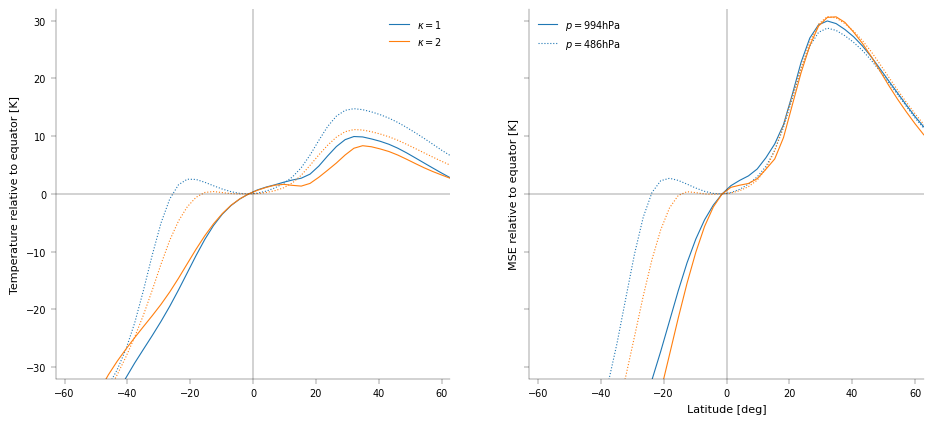

In [9]:
fig, ax = plt.subplots(1,2, figsize=(3.5*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[0].plot(ds[0].lat, temp_surf[i]-temp_surf[i, ind_eq], color=default_colors[i], label=f'$\kappa = {tau_lw[i]}$')
    ax[0].plot(ds[0].lat, temp_ft[i]-temp_ft[i, ind_eq], color=default_colors[i], linestyle=':')
    ax[1].plot(ds[0].lat, mse_surf[i]-mse_surf[i, ind_eq], color=default_colors[i], label=f'$p = {int(p_surface/100)}$hPa' if i==0 else None)
    ax[1].plot(ds[0].lat, mse_ft[i]-mse_ft[i, ind_eq], color=default_colors[i], linestyle=':', label=f'$p = {int(p_ft/100)}$hPa' if i==0 else None)
ax[0].set_xlim(-ds[0].lat.max(), ds[0].lat.max())
ax[0].set_ylim(-30, ax[0].get_ylim()[1])
ax[0].set_ylim(-32, 32)
for i in range(len(ax)):
    ax[i].legend()
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axvline(0, color='k', lw=ax_linewidth)
ax[1].legend()
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Temperature relative to equator [K]')
ax[1].set_ylabel('MSE relative to equator [K]');

### Breakdown of $\delta \Delta h^*_{FT}$
Above we see that despite the temperature relative to the equator at the free troposphere decreasing with warming, ($\delta \Delta T_{FT}<0$), the saturated MSE at the free troposphere relative to the equator does not.
This is due to the sensitivity of $q^*$ to the starting temperature.
Doing a linear taylor series, we have:

$\Delta q^* \approx \alpha_0 q_0^*\Delta T$;

$\delta \Delta q^* \approx \alpha_0 q^*_0 \Delta T (\alpha_0 - 2/T_0)\delta T_0 + \alpha_0 q^*_0 \delta \Delta T + 
\alpha_0 q^*_0 (\alpha_0 - 2/T_0)\delta T_0 \delta \Delta T$

where the $0$ subscript refers to the equatorial value. The first term in the $\delta \Delta q^*$ expansion is always positive, hence $\delta \Delta q^*$ can be positive for negative $\delta \Delta T$.

In [10]:
# mse_ft = np.zeros((n_exp, n_lat))       # in units of K
# z_ft = np.zeros((n_exp, n_lat))
# temp_ft = np.zeros((n_exp, n_lat))
# for i in range(n_exp):
#     if 'height' in ds[0]:
#         ds_use = ds[i].isel(pfull=ind_ft)[['temp', 'height']].mean(dim='time')
#     else:
#         ds_use = ds[i].isel(pfull=ind_ft)[['temp']]
#         ds_use['height'] = get_z_ft_approx(ds_use.temp, ds_use.temp, p_surface, p_ft) * np.asarray([0, 1]).reshape(1, 2, 1)
#     
#     mse_ft[i] = moist_static_energy(ds_use.temp, sphum_sat(ds_use.temp, p_ft), ds_use.height)*1000/c_p
#     z_ft[i] = ds_use.height
#     temp_ft[i] = ds_use.temp
mse_ft_diff_eq = mse_ft - mse_ft[:, ind_eq][:, np.newaxis]
temp_ft_diff_eq = temp_ft - temp_ft[:, ind_eq][:, np.newaxis]
z_ft_diff_eq = z_ft - z_ft[:, ind_eq][:, np.newaxis]
temp_ft_0 = temp_ft[0, ind_eq]
q_sat_ft_0 = sphum_sat(temp_ft_0, p_ft)
alpha_ft_0 = clausius_clapeyron_factor(temp_ft_0, p_ft)
temp_ft_0_change = temp_ft[1, ind_eq] - temp_ft[0, ind_eq]

mse_diff_eq_change_terms = {'temp_0': L_v * alpha_ft_0 * q_sat_ft_0 * temp_ft_diff_eq[0] * (alpha_ft_0 - 2/temp_ft_0)*temp_ft_0_change,
                            'temp_eq_diff': (c_p + L_v * alpha_ft_0 * q_sat_ft_0) * (temp_ft_diff_eq[1]-temp_ft_diff_eq[0]),
                            'non_linear': L_v * alpha_ft_0 * q_sat_ft_0 * (alpha_ft_0 - 2/temp_ft_0)*
                                          temp_ft_0_change*(temp_ft_diff_eq[1]-temp_ft_diff_eq[0]),
                            'z': g * (z_ft_diff_eq[1]-z_ft_diff_eq[0])}
for key in mse_diff_eq_change_terms:
    mse_diff_eq_change_terms[key] = mse_diff_eq_change_terms[key]/c_p       # convert to units of K

In [11]:
print(temp_ft_0)
print(temp_ft_0_change)
print(temp_ft_diff_eq[0].max())
print(float(ds[0].lat[temp_ft_diff_eq[0].argmax()]))
print((temp_ft_diff_eq[1]-temp_ft_diff_eq[0])[temp_ft_diff_eq[0].argmax()])
print((mse_diff_eq_change_terms['temp_0']/temp_ft_0_change)[temp_ft_diff_eq[0].argmax()])
print((mse_diff_eq_change_terms['temp_eq_diff']/(temp_ft_diff_eq[1]-temp_ft_diff_eq[0]+1e-20))[0])

256.4871520996094
12.65533447265625
14.7623291015625
32.09194388174401
-3.61810302734375
0.4985643747565142
1.4447864159796182


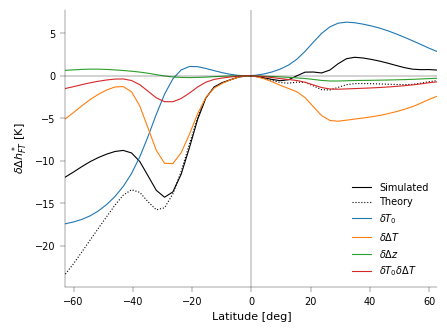

In [12]:
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax.plot(ds[0].lat, mse_ft_diff_eq[1]-mse_ft_diff_eq[0], color='k', label='Simulated')
ax.plot(ds[0].lat, sum(mse_diff_eq_change_terms.values()), color='k', linestyle=':', label='Theory')
ax.plot(ds[0].lat, mse_diff_eq_change_terms['temp_0'], color=default_colors[0], label='$\delta T_0$')
ax.plot(ds[0].lat, mse_diff_eq_change_terms['temp_eq_diff'], color=default_colors[1], label='$\delta \Delta T$')
ax.plot(ds[0].lat, mse_diff_eq_change_terms['z'], color=default_colors[2], label='$\delta \Delta z$')
ax.plot(ds[0].lat, mse_diff_eq_change_terms['non_linear'], color=default_colors[3], label='$\delta T_0 \delta \Delta T$')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.legend()
ax.set_xlim(-ds[0].lat.max(), ds[0].lat.max())
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$\delta \Delta h_{FT}^*$ [K]');

### Problem with $\Delta q^*$ Expansion
Above, we see the theory is not a particularly good match for the simulated value. This is because a squared (or even cubed for winter hemisphere) term is really needed in the $\Delta q^*$ expansion i.e.

$\Delta q^* \approx \alpha_0 q_0^*\left(\Delta T + \frac{1}{2}(\alpha_0 - 2/T_0)\Delta T^2\right)$

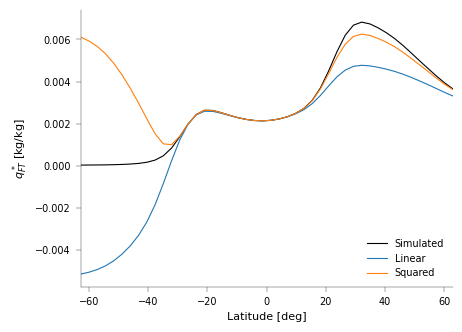

In [13]:
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax.plot(ds[0].lat, sphum_sat(temp_ft[0], p_ft), color='k', label='Simulated')
ax.plot(ds[0].lat, sphum_sat(temp_ft_0, p_ft) * (1 + alpha_ft_0 * temp_ft_diff_eq[0]), color=default_colors[0], label='Linear')
ax.plot(ds[0].lat, sphum_sat(temp_ft_0, p_ft) * 
        (1 + alpha_ft_0 * temp_ft_diff_eq[0] + 0.5 * temp_ft_diff_eq[0]**2 * alpha_ft_0/temp_ft_0*(alpha_ft_0*temp_ft_0-2)), 
        color=default_colors[1], label='Squared')
ax.legend()
ax.set_xlim(-ds[0].lat.max(), ds[0].lat.max())
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$q_{FT}^*$ [kg/kg]');

## Circulation changes
We see that with warming, $v$ becomes less northward at the surface, and $\omega$ becomes less upward at the north edge of the Hadley cell.

With warming, it appears that $v$ remains northward up to a higher altitude. This may offset the reduction in $v$ at the surface when 
it comes to mass conservation.

There certainly seems to be a split around 500hPa, below this (closer to the surface) the circulation gets weaker with warming. Above it, the circulation gets stronger with warming.

This is also reflected in $\omega$. With warming, we see less (more) ascent below (above) 500hPa at the northward edge of the cell.

We see that the most negative $u$ stays pretty constant with warming, but moves to a higher altitude. By thermal wind, you would expect the most negative $u$ to become less negative with warming because the temperature gradient, $dT/dy$ becomes less positive at this latitude.

In [14]:
stream = np.zeros((n_exp, n_pressure, n_lat))
for i in range(n_exp):
    for j in range(n_pressure):
        # integrate from surface each time, hence weird indexing
        ds_use = ds[i].vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)).mean(dim='time')
        stream[i, ind_surf-j] = get_stream(ds_use, ds_use.pfull*100, ds_use.lat)

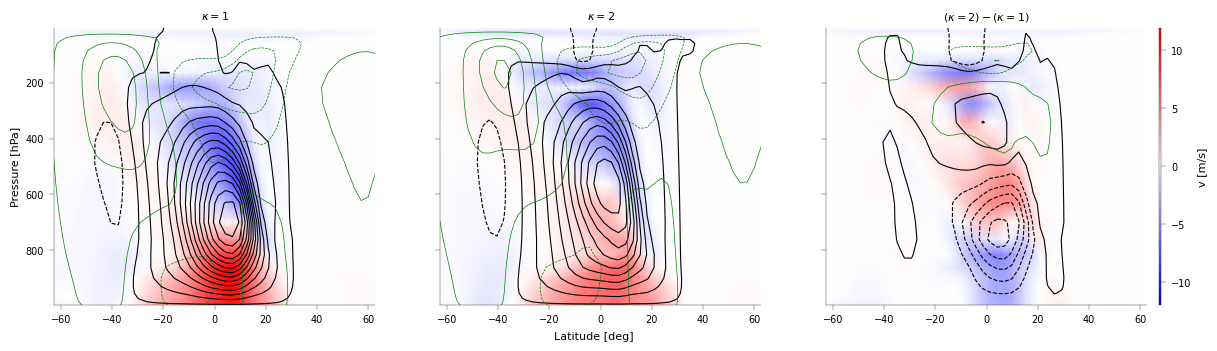

In [15]:
var = {'v': np.asarray([ds[i].mean(dim='time').vcomp.to_numpy() for i in range(n_exp)]), 
       'u': np.asarray([ds[i].mean(dim='time').ucomp.to_numpy() for i in range(n_exp)]),
       'dTdy': np.asarray([grad_y(ds[i].temp.mean(dim='time'), ds[0].lat, lat_axis=-1) for i in range(n_exp)])}
if 'omega' in var_keep:
    var['omega'] = np.asarray([ds[i].mean(dim='time').omega.to_numpy() for i in range(n_exp)])
var_units = {'v': 'm/s', 'u': 'm/s', 'omega': 'Pa/s', 'dTdy': 'K/m'}
step_level = {'stream': 50e9*1.5, 'u': 20}
levels = {'stream': np.arange(-np.abs(stream).max(), np.abs(stream).max() + step_level['stream'], step_level['stream']), 
          'u': np.arange(-np.abs(var['u']).max(), np.abs(var['u']).max() + step_level['u'], step_level['u'])}
var_color = 'v'
fig, ax = plt.subplots(1,3, figsize=(3*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True, sharex=True)
for i in range(n_exp):
    ax[i].contour(ds[i].lat, ds[i].pfull, stream[i], colors='k', levels=levels['stream'])
    ax[i].contour(ds[i].lat, ds[i].pfull, var['u'][i], colors='green', levels=levels['u'], linewidths=0.5)
    ax[i].pcolormesh(ds[i].lat, ds[i].pfull, var[var_color][i], 
                          cmap='bwr', shading='gouraud', vmax=np.max(np.abs(var[var_color])), vmin=-np.max(np.abs(var[var_color])))
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[2].contour(ds[0].lat, ds[0].pfull, stream[1]-stream[0], colors='k', levels=levels['stream'])
ax[2].contour(ds[0].lat, ds[0].pfull, var['u'][1]-var['u'][0], colors='green', levels=levels['u'], linewidths=0.5)
im = ax[2].pcolormesh(ds[0].lat, ds[0].pfull, var[var_color][1]-var[var_color][0], 
                      cmap='bwr', shading='gouraud', vmax=np.max(np.abs(var[var_color])), vmin=-np.max(np.abs(var[var_color])))
fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.01, fraction=0.01, label=f"{var_color} [{var_units[var_color]}]")
ax[2].set_title(f'$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$')
ax[0].invert_yaxis()
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]');

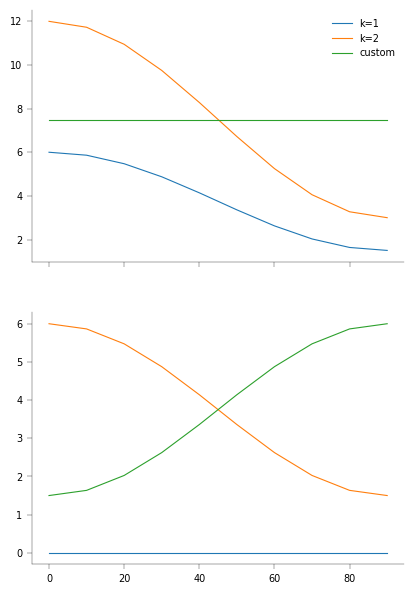

In [43]:
def get_tau_surf(lat, kappa=1, tau_e=6, tau_p=1.5):
    return kappa * (tau_e + (tau_p - tau_e) * np.sin(np.deg2rad(lat))**2)
tau_surf_lat = np.linspace(0, 90, 10)
tau_surf = {'k=1': get_tau_surf(tau_surf_lat), 'k=2': get_tau_surf(tau_surf_lat, kappa=2), 
            'custom': get_tau_surf(tau_surf_lat, kappa=1.25, tau_p=6)}

fig, ax = plt.subplots(2,1, figsize=(1.5*width['one_col'], 2*1.5*width['one_col']/ar), sharex=True)
for i, key in enumerate(tau_surf):
    ax[0].plot(tau_surf_lat, tau_surf[key], label=key, color=default_colors[i])
    ax[1].plot(tau_surf_lat, tau_surf[key]-tau_surf['k=1'], label=key, color=default_colors[i])
ax[0].legend()

In [42]:
get_tau_surf(tau_surf_lat, kappa=1.25, tau_p=6)

array([7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5])